In [1]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [2]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from data_retrieval import lipade_groundtruth
from data_retrieval.tools.data_loader import getDataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizerFunc = optim.Adam
temperature = 0.5
learningRate = 1e-3
batch_size = 512
workers = 2
corpus = "lipade_groundtruth"
resultsPath = "../results/distance/" + corpus + "/"


## Dataset

In [3]:
x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

images = []
for i in range(len(x[:10])):
    images.append(Image.open(x[i]).convert('RGB'))

In [4]:
x = np.array(x)
y = np.array(y)
images = np.array(images)

images.shape

(10, 256, 256, 3)

In [5]:
trainLoader = getDataLoader(images, None, None, False, batch_size, True, num_workers=2)

## Transformations

In [6]:
from degradations.methods.halftoning.floyd_steinberg import transforms_floyd_steinberg_halftoning
from degradations.methods.halftoning.atkinson import transforms_atkinson_dithering
from degradations.methods.halftoning.bayers_threshold import transforms_bayer_halftoning
from degradations.methods.halftoning.dot_traditional import transforms_dot_halftoning  # Import your halftoning methods
from degradations.methods.noise.gaussian_noise import transforms_add_gaussian_noise
from degradations.methods.noise.salt_and_pepper import transforms_add_salt_and_pepper_noise
from degradations.methods.noise.dirty_rollers import transforms_dirty_rollers
#from degradations.methods.noise.film_grain import transforms_apply_film_grain # Import your noise methods
from degradations.methods.paper.ink_bleed import transforms_ink_bleed  
from degradations.methods.paper.crumpled_paper import transforms_crumpled_paper
from degradations.methods.paper.folded_paper import transforms_folded_paper
from degradations.methods.paper.bleedthrough import transforms_bleedthrough
from degradations.methods.paper.scribbles import transforms_scribbles
from degradations.methods.paper.torn_paper import transforms_torn_paper
from degradations.methods.paper.stains import transforms_stains # Import your paper feel methods
from degradations.methods.human_corrections.erased_element import transforms_erased_element # Import your human correction methods
from degradations.methods.layout.picture_overlay import transforms_picture_overlay
from degradations.methods.layout.text_overlay import transforms_text_overlay # Import your layout methods


In [7]:
# Sepia or grayscale possibly flipped

class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super(transforms_SepiaFilter, self).__init__()

    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)


# possible +/- 45 degrees rotations, possibly cropped

class transforms_Rotate(nn.Module):
    def __init__(self):
        super(transforms_Rotate, self).__init__()

    def __call__(self, batch):
        batch = batch.movedim(2,3)    
        return batch

### Transformations classiques

In [24]:
# Transformations de base pour SimCLR
transform_simclr = transforms.Compose([
    transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5,1), ratio=(1,1)),  # Recadrage aléatoire suivi d'un redimensionnement
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),  # Distorsions de couleur
    transforms.GaussianBlur(kernel_size=9)  # Flou gaussien aléatoire
])

### Transformations Fei

In [25]:
transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.Grayscale(num_output_channels=3),
        transforms_SepiaFilter()
    ]),
    transforms.RandomHorizontalFlip(p=0.5)
])

transform2 = transforms.Compose([
    transforms.RandomApply([
        transforms_Rotate(),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(1),
            transforms.RandomVerticalFlip(1)
        ])], 2/3),
    transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5,1), ratio=(1,1))
])

In [26]:
transformRandom = transforms.RandomChoice([transform1, transform2])

### Transformations étendues

In [8]:
transform_halftone = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_floyd_steinberg_halftoning(),
            transforms_atkinson_dithering(),
            transforms_bayer_halftoning()
            ])
        ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#

transform_noise = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_add_gaussian_noise(),
                transforms_add_salt_and_pepper_noise(),
                transforms_dirty_rollers((3,5))
            ])
        ], p=0.5),
        transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#

transform_layout = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_picture_overlay(),
                transforms_text_overlay(),
                transforms_torn_paper(),
            ])
        ], p=0.5),
        transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#
transform_texture = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_crumpled_paper(),
            transforms_folded_paper(),   
        ])
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#
transform_stains = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_scribbles(),
            transforms_stains(), 
            transforms_ink_bleed(),
            transforms_bleedthrough(),
        ])
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5)
])


#------------------------------------------#
transform_erased = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.RandomApply([
        transforms_erased_element()
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(kernel_size=5)
])


#------------------------------------------#
transform_degrad = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(1/2, 1), ratio=(1, 1))
    ], p=1/3),

    # halftone
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_floyd_steinberg_halftoning(),
            transforms_atkinson_dithering(),
            transforms_bayer_halftoning()
            ])
        ], p=0.2),

    # layout
    transforms.RandomApply([
            transforms.RandomChoice([
                transforms_picture_overlay(),
                transforms_text_overlay(),
                transforms_torn_paper(),
            ])
    ], p=0.2),

    # erased
    transforms.RandomApply([
        transforms_erased_element()
    ], p=0.1),

    # noise
    transforms.RandomApply([
            transforms.RandomChoice([
                transforms_add_gaussian_noise(),
                transforms_add_salt_and_pepper_noise(),
                transforms_dirty_rollers()
            ])
    ], p=0.2),

    # stains
    transforms.RandomApply([
        transforms.RandomChoice([
            #transforms_scribbles(),
            transforms_stains(), 
            transforms_ink_bleed(),
            transforms_bleedthrough(),
        ])
    ], p=0.3),

    # texture
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_crumpled_paper(),
            transforms_folded_paper(0.4),   
        ])
    ], p=0.2),

    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
    transforms.RandomApply([transforms_SepiaFilter()], p=0.2)
])


(0, 20) (0, 34)
(0, 36) (0, 65)


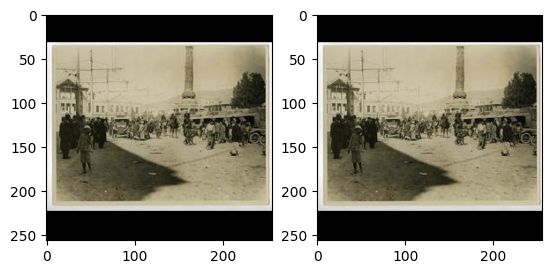

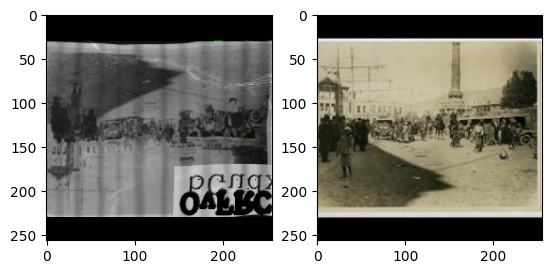

In [36]:
for batch in trainLoader:
    batch1 = transform_degrad(batch)
    batch2 = transform_degrad(batch)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch[0]))
    plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch1[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch2[0]))
    plt.show()
    break

## Representation

In [28]:
class SimCLR_Representation(nn.Module):
    def __init__(self, encoder, in_dim=2048, out_dim=128):
        super(SimCLR_Representation, self).__init__()
        self.encoder = encoder
        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    
    def forward(self, x_):
        h = self.encoder(x_)
        z = self.projection(h)
        return z

In [4]:
# ResNet18
representationEncoder = resnet18(weights=ResNet18_Weights.DEFAULT)
representationEncoder.fc = nn.Identity()

# ResNet50
#representationEncoder = resnet50(weights=ResNet50_Weights.DEFAULT)
#representationEncoder.fc = nn.Identity()
#model = SimCLR_Representation(representationEncoder, in_dim=2048).to(device)  # in_dim updated for ResNet50

# # MobileNet
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# representationEncoder = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
# representationEncoder.classifier = nn.Identity()  # Remove classification head
# model = SimCLR_Representation(representationEncoder, in_dim=1280).to(device)  # in_dim for MobileNetV2


### Loss

In [7]:
def infoNCEloss(z1, z2, t=1): # loss 1
    z = torch.cat([z1, z2], dim=0)

    s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
    exp_s = torch.exp(s / t)
    indicatorMask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device) # True on diagonal, False elsewhere
    exp_s = exp_s.masked_fill(indicatorMask, 0)

    numerator = F.cosine_similarity(z1, z2, dim=-1)      # for z1
    numerator = torch.cat([numerator, numerator], dim=0) # for z2
    numerator = torch.exp(numerator / t)

    denominator = exp_s.sum(dim=1)

    l = -torch.log(numerator / denominator)
    return l.mean()

# def infoNCE_loss(z1, z2, t=1.0): # loss 2
#     """
#     Computes the InfoNCE loss  for contrastive learning.

#     z1: Tensor of shape (batch_size, feature_dim), first augmented view.
#     z2: Tensor of shape (batch_size, feature_dim), second augmented view.
#     t: Temperature parameter.
#     """
#     z = torch.cat([z1, z2], dim=0)  # Concatenate both views

#     # Compute cosine similarity matrix
#     s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)  # (2N, 2N)

#     # Apply temperature scaling and exponentiation
#     exp_s = torch.exp(s / t)

#     # Create a mask to exclude self-comparisons
#     mask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device)
#     exp_s = exp_s.masked_fill(mask, 0)  # Zero out diagonal elements (self-similarity)

#     # Extract positive pairs (i.e., (z1[i], z2[i]) and (z2[i], z1[i]))
#     batch_size = z1.shape[0]
#     pos_pairs = torch.cat(
#         [s[range(batch_size), range(batch_size, 2 * batch_size)],
#          s[range(batch_size, 2 * batch_size), range(batch_size)]]
#     )  # Extract diagonal offsets

#     # Compute numerator (positive pair similarities)
#     numerator = torch.exp(pos_pairs / t)

#     # Compute denominator (sum over all negatives)
#     denominator = exp_s.sum(dim=1)

#     # Compute loss
#     loss = -torch.log(numerator / denominator)
#     return loss.mean()

## Train

#### degrad avant resize :

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from data_retrieval.tools.uniformize_image import uniformize_image

class DegradationsDataset(Dataset):
    def __init__(self, image_paths, degrad):
        self.image_paths = image_paths
        self.degrad = degrad
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")  # Keep original size

        degrad_img = self.degrad(self.to_tensor(img).unsqueeze(0)).squeeze(0)
        degrad_img = transforms.functional.to_pil_image(degrad_img)

        img = uniformize_image(img, 256, False)
        degrad_img = uniformize_image(degrad_img, 256, False)

        img = self.to_tensor(img)
        degrad_img = self.to_tensor(degrad_img)
        return img, degrad_img


# Load your dataset
x, _, _ = lipade_groundtruth.getDataset(mode='unique', uniform=False)  # Don't resize here


dataset = DegradationsDataset(x[:2], transformRandom) # test pour visualiser images
trainLoader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)


In [28]:
img, degrad = dataset[0]

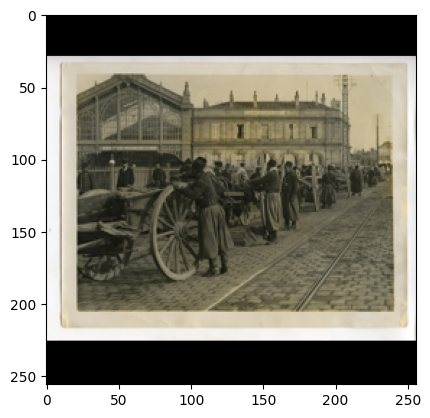

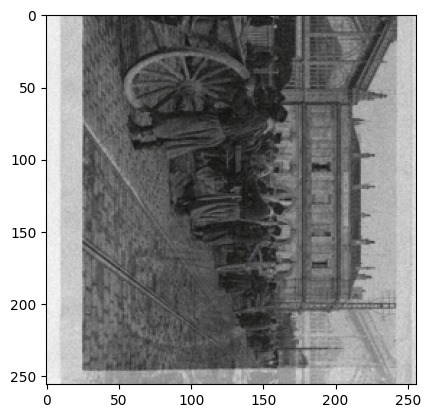

In [29]:
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
plt.imshow(transforms.functional.to_pil_image(degrad))

In [42]:
torch.cuda.empty_cache()

In [ ]:
dataset = DegradationsDataset(x, transformRandom) # vrai dataset
trainLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#### train normal

In [5]:
model = SimCLR_Representation(representationEncoder, in_dim=512).to(device)
optimizer = optimizerFunc(model.parameters(), lr=learningRate)

In [44]:
lastBatch = images.shape[0] // batch_size

In [ ]:
epochs = 200
writer = SummaryWriter(log_dir="logs/SimCLR")
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)  

model.train()

losses_all = []
for epoch in range(epochs):
    losses = []
    for i,sampledMinibatch in enumerate(tqdm(trainLoader, desc="Epoch " + str(epoch))):
        x = sampledMinibatch.to(device)
        # Transformation
        x_2 = transformRandom(x)
        #x_2 = transform_simclr(x)
        # Representation
        z1 = model(x)
        z2 = model(x_2)
        # Loss
        loss = infoNCEloss(z1, z2, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i != lastBatch:
            losses.append(loss.item())

    writer.add_scalar("Loss/train", torch.tensor(losses).mean(), epoch)
    losses_all.append(torch.tensor(losses).mean())
    torch.save(model.state_dict(), "model_weights2.pth")
    scheduler.step()

plt.plot(losses_all)
plt.show()


## Test

In [3]:
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)

imagesSim = []
for i in range(len(xSim)):
    try:
        imagesSim.append(Image.open(xSim[i]).convert('RGB'))
    except:
        print(xSim[i])

In [7]:
model.load_state_dict(torch.load('../results/model_transfer.pth', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)

In [9]:
representations = []
with torch.no_grad():
    for batch in testLoader:
        batch = model(batch.to(device))
        for repr in batch.tolist():
            representations.append(repr)

In [10]:
sim = cosine_similarity(representations, representations)

distance = 1 - (sim+1)/2
distance -= np.diag(distance)

In [11]:
np.save(resultsPath + "simclr_transfer.npy", distance)

## Test embedding transformations

In [8]:
import seaborn as sns
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor

In [9]:
# SimCLR Feature Extractor
class SimCLRFeatureExtractor(nn.Module):
    def __init__(self, encoder=None, in_dim=512, out_dim=128):
        super(SimCLRFeatureExtractor, self).__init__()
        if encoder is None:
            self.encoder = resnet18(weights=ResNet18_Weights.DEFAULT)
            self.encoder.fc = nn.Identity()
        else:
            self.encoder = encoder

        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.encoder(x)


In [10]:
# Dataset avec Transformations
class HistoricalDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        original = to_tensor(self.images[idx])
        transformed = self.transform(original.unsqueeze(0)).squeeze(0) if self.transform else original
        return original, transformed

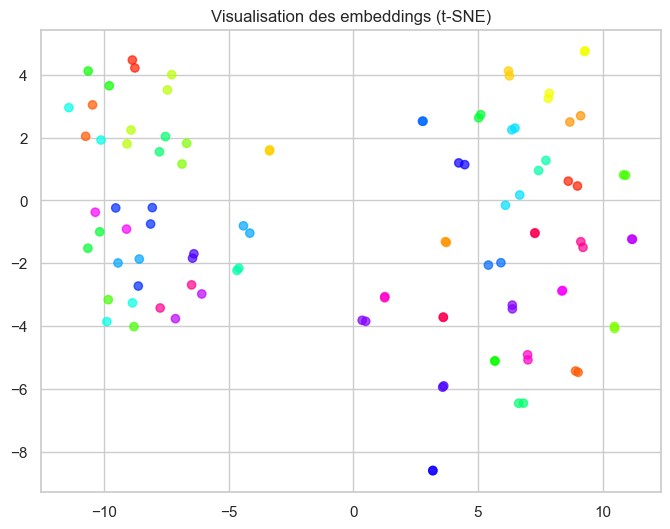

In [ ]:

# Fonction de Visualisation
def visualize_embeddings(embeddings, labels):
    sns.set_theme(style="whitegrid")
    
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)

    reduced = reducer.fit_transform(embeddings)

    num_classes = len(labels)//2 
    palette = sns.color_palette("hsv", num_classes) 
    colors = [palette[label % num_classes] for label in labels]  # Associer chaque label à une couleur unique


    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, alpha=0.7)
    #plt.colorbar(scatter)
    plt.title(f"Visualisation des embeddings (t-SNE)")
    plt.show()


# Chargement du modèle et extraction des embeddings
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for idx, (orig, trans) in enumerate(dataloader):
            orig, trans = orig.to(device), trans.to(device)
            
            emb_orig = model(orig).cpu().numpy()
            emb_trans = model(trans).cpu().numpy()
            
            embeddings.append(emb_orig)
            embeddings.append(emb_trans)
            
            labels.append(idx*2)  # Label pour original
            labels.append(idx*2)  # Label pour transformé
    return np.vstack(embeddings), np.array(labels)


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SimCLRFeatureExtractor().to(device)
    model.load_state_dict(torch.load('../results/model_moi_2nd_try.pth', weights_only=True, map_location=torch.device('cpu')))
    

    x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

    images = []
    for i in range(len(x[:50])):
        images.append(Image.open(x[i]).convert('RGB'))
    images = np.array(images)

    transform_degrad = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomResizedCrop(size=images.shape[2], scale=(1/2, 1), ratio=(1, 1))
        ], p=1/3),

        # halftone
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_floyd_steinberg_halftoning(),
                transforms_atkinson_dithering(),
                transforms_bayer_halftoning()
                ])
            ], p=0.2),

        # layout
        transforms.RandomApply([
                transforms.RandomChoice([
                    transforms_picture_overlay(),
                    transforms_text_overlay(),
                    transforms_torn_paper(),
                ])
        ], p=0.2),

        # erased
        transforms.RandomApply([
            transforms_erased_element()
        ], p=0.1),

        # noise
        transforms.RandomApply([
                transforms.RandomChoice([
                    transforms_add_gaussian_noise(),
                    transforms_add_salt_and_pepper_noise(),
                    transforms_dirty_rollers()
                ])
        ], p=0.2),

        # stains
        transforms.RandomApply([
            transforms.RandomChoice([
                #transforms_scribbles(),
                transforms_stains(), 
                transforms_ink_bleed(),
                transforms_bleedthrough(),
            ])
        ], p=0.3),

        # texture
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_crumpled_paper(),
                #transforms_folded_paper(),   
            ])
        ], p=0.2),

        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
        transforms.RandomApply([transforms_SepiaFilter()], p=0.2)
    ])

    
    dataset = HistoricalDataset(images, transform_degrad)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Extraire les embeddings
    embeddings, labels = extract_embeddings(model, dataloader, device)

    # Visualiser
    visualize_embeddings(embeddings, labels)
